<a href="https://colab.research.google.com/github/andreregino/machine-learning-classes/blob/main/MO444_Projeto_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the required libs
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_samples, silhouette_score
from scipy.spatial import distance as dt
from copy import deepcopy
from IPython.display import display, HTML
from sklearn.decomposition import PCA
import sys
import time

# setting the fonts for graphs
title_font = {'family': 'serif',
        'weight': 'bold',
        'size': 15,
        'style':'italic'}

axis_font = {'family': 'serif',
        'size': 14,
        'style':'italic'}
plt.style.use('ggplot')

## Part I - Clustering methods
The work consists of implementing k-means and another unsupervised learning method of your group’s choice.

You are not allowed to use a library (like sklearn) that implements the methods at this point. Hence, you are supposed to offer an implementation for a k-means function and a myOtherULMethod function.

### Part I-A: Implementing 2d standard task

In [2]:
# Class implementation of DBSCAN algorithm
class DBSCAN():
    
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
    
    def get_distance(self, i, j):
        """This method returns the euclidian distance between 2 data points.
        
        Parameters
        ----------
        i, j : numpy array
          Features arrays.
          
        Returns
        -------
        distance: float
          Euclidian distance between i and j.
        """
        return dt.euclidean(i, j)
    
    def get_neigh_predict(self, x_i):
        """This method returns the neighboors of new point x_i.
        
        Parameters
        ----------
        x_i : numpy array
          New point to predict.
          
        Returns
        -------
        neigh: numpy array
          Neighboors of x_i in a distance eps.
        """
        neigh = []
        indices = np.arange(self.len_data)
        
        for j in range(self.len_data):
            dst = self.get_distance(self.data[j], x_i)
            if dst <= self.eps:
                neigh.append(j)
        return np.array(neigh)
        
    def get_neigh(self, x_i):
        """This method returns the neighboors of point in position x_i.
        
        Parameters
        ----------
        x_i : int
          Position of the point x_i.
          
        Returns
        -------
        neigh: numpy array
          Neighboors of x_i in a distance eps.
        """
        neigh = []
        indices = np.arange(self.len_data)
        
        for j in indices[indices != x_i]:
            dst = self.get_distance(self.data[x_i], self.data[j])
            if dst <= self.eps:
                neigh.append(j)
                
        return np.array(neigh)
    
    def expand_cluster(self, x_i, neigh):
        """Recursive method that expand cluster based on core points in an 
        eps distance.
        
        Parameters
        ----------
        x_i : int
          Position of the point x_i.
        neigh : numpy array
          Neighboors of the point x_i
          
        Returns
        -------
        cluster: numpy array
          Cluster based in the expand of core points.
        """
        cluster = [x_i]
        
        for n_i in neigh:
            if not n_i in self.visited:
                self.visited.append(n_i)
                
                self.neigh[n_i] = self.get_neigh(n_i)
                if len(self.neigh[n_i]) >= self.min_samples:
                    self.point_type[n_i] = 'CORE'
                    
                    cluster_exp = self.expand_cluster(n_i, self.neigh[n_i])
                    cluster = cluster + cluster_exp
                else:
                    self.point_type[n_i] = 'BORDER'
                    cluster.append(n_i)
        return cluster
    
    def clusters_labels(self):
        """This method set a label based on the cluster.
        
        Returns
        -------
        labels: numpy array
          Array where the position represents a cluster id.
        """
        self.labels = np.full(shape=self.data.shape[0], fill_value=len(self.clusters))
        for cluster_i, cluster in enumerate(self.clusters):
            for sample_i in cluster:
                self.labels[sample_i] = cluster_i
                
        return self.labels
    
    def fit(self, X):
        """This methods train the algorithm based and return the clusters labels
        of the train data.
        
        Parameters
        ----------
        X : numpy array
          Data to training the algorithm.
          
        Returns
        -------
        cluster_labels: numpy array
          Cluster labels of the train data.
        """
        self.data = X
        self.len_data = len(self.data)
        self.point_type = {key: 'OUTLIER' for key in range(self.len_data)}
        
        self.clusters = []
        self.visited = []
        self.neigh = {}
        
        for x_i in range(self.len_data):
            
            if x_i in self.visited:
                continue

            self.neigh[x_i] = self.get_neigh(x_i)
            if len(self.neigh[x_i]) >= self.min_samples:
                self.point_type[x_i] = 'CORE'
                self.visited.append(x_i)
                
                n_cluster = self.expand_cluster(x_i, self.neigh[x_i])
                
                self.clusters.append(n_cluster)
        return self.clusters_labels()
    
    def predict_value(self, x_i):
        """This methods predict a new single value based in the clusters labels 
        of the train data.
        
        Parameters
        ----------
        x_i : numpy array
          New data to prediction.
          
        Returns
        -------
        cluster_label: int
          Cluster labels of the value.
        """
        neigh_x_i = self.get_neigh_predict(x_i)
        
        if len(neigh_x_i)==0:
            return -1
        else:
            points_neigh = dict((key,value) for key, value in self.point_type.items() if key in neigh_x_i)
            
            core_points = list(key for key, value in self.point_type.items() if value == 'CORE')

            if len(core_points)==1:
                return self.labels[core_points[0]]
            
            elif len(core_points)>1:
                dist = {}
                for x_j in core_points:
                    dist[x_j] = self.get_distance(self.data[x_j], x_i)
                    
                dist_orders = sorted(dist.items(), key=lambda x: x[1])
                cluster, dist = dist_orders[0]
                
                return self.labels[cluster]
            
            else: 
                return -1
    
    def predict(self, X):
        outputs = []
        
        for x_i in X:
            outputs.append(self.predict_value(x_i))
        return outputs

In [3]:
# normalization of data with standardization method
def normalize(data):
    """This methods normalize the data, where the columns have mean 0 and std 1.
        
    Parameters
    ----------
    data : numpy array
      Data to normalize.
 
    Returns
    -------
    X: numpy array
      Data normalized.
    """
    X = data
    for i in range(data.shape[1]):
        c_i = np.array(data[:,i])

        u = c_i.mean()
        s = c_i.std()

        X[:,i] = (c_i-u)/s
    return X

#### Implementing k means

In [5]:
# initializing centers (random)
def init_centers_random(M, number_centers):
  return np.random.randn(number_centers,M.shape[1]) * np.std(M, axis = 0) + np.mean(M, axis = 0)

In [6]:
# function that implements the initialization with k-means++
def kmeans_plus_plus(X, k):
    """This methods initializate the clusters of Kmeans algorithm based on the 
    algorithm kmeans++.
        
    Parameters
    ----------
    X : numpy array
      Data to training the algorithm.
    
    k : int
      Number of clusters
          
    Returns
    -------
    centers: numpy array
      Initial centers to the Kmeans.
    """
    centers = []
    
    c_1 = X[np.random.randint(len(X)), :]
    centers.append(c_1)
    
    for c_j in range(1, k):
        dist = []
        
        for i in range(len(X)):
            x_i = X[i, :]
            min_dst = sys.maxsize
            
            for c in range(len(centers)):
                min_dst = min(min_dst, dt.euclidean(x_i, centers[c]))
            dist.append(min_dst)   
            
        dist = np.array(dist)
        dist_p2 = dist**2
        prob_dist = dist_p2/dist_p2.sum()
        
        new_center = X[np.argmax(prob_dist), :]
        centers.append(new_center)
    return np.array(centers)

In [7]:
# plotting
def plot_graphs(np_data, color):
  for i in range(np_data.shape[0]):
    plt.scatter(np_data[i, 0], np_data[i,1], c=color)

In [8]:
# k means fit function
def kmeans(data, k, init):
  
  # number of rows
  n = data.shape[0]
  # Number columns (features)
  c = data.shape[1]

  # depending on the init function, calls random initialization or k-means++ initialization
  if init == "random":
    centers = init_centers_random(data, k)
  else:
    centers = kmeans_plus_plus(data, k)
  init_centers = centers
  
  # variables to store the centers in the current and previous iteration
  centers_old = np.zeros(centers.shape) 
  centers_new = deepcopy(centers) 

  # initially zero-filling clusters and distances
  clusters = np.zeros(n)
  distances = np.zeros((n,k))

  # setting initial error value > 0
  error = np.linalg.norm(centers_new - centers_old)
  
  # if the error is minimized to zero, the loop ends, no movement in the centroids
  while error != 0:
      
      # distance of data entries and centroids
      for i in range(k):
          distances[:,i] = np.linalg.norm(data - centers_new[i], axis=1)
      
      # clusters receives the ones with minimum distance
      clusters = np.argmin(distances, axis = 1)
      
      centers_old = deepcopy(centers_new)
     
      # Calculate mean for every cluster and update the center
      for i in range(k):
          centers_new[i] = np.mean(data[clusters == i], axis=0)
      error = np.linalg.norm(centers_new - centers_old)
  
  # if number of dimensions is less or equal than 3, plot the data
  if c <= 2:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    display(HTML(str("<font size=3><b> k = </b></font>" + str(k))))
    ax1.scatter(data[:, 0], data[:,1])  
    ax1.scatter(init_centers[:, 0], init_centers[:,1])
  
    ax1.set_title('Initial centroids position', fontdict=title_font)

    cent = []
    for points in train_db:
      cent.append(distance_point_centroid(points, centers_new))
    
    for g in np.unique(cent):
        ix = np.where(cent == g)
        ax2.scatter(data[ix,0], data[ix,1], label = g)
    ax2.scatter(centers_new[:, 0], centers_new[:,1], color='black')
    ax2.set_title('Cluster Distribution', fontdict=title_font)
    ax2.legend()
    plt.show()

  # store cluster id of each datapoint
  cluster_assignment = []
  for points in data:
    cluster_assignment.append(distance_point_centroid(points, centers_new))  

  return centers_new, cluster_assignment

In [9]:
# calculate the distance of a certain point to a centroid
def distance_point_centroid(data_point, centers):
  #initially assigning a big number so the first euclidean dist will be the shortest
  min_dst = 100000 
  c = 0
  for c in range(len(centers)):
    euclidean_dist = dt.euclidean(data_point, centers[c])
    if euclidean_dist < min_dst:
        min_dst = euclidean_dist
        min_c = c
  #plot_color_clusters(data_point, min_c)
  return min_c

In [10]:
# function to predict k means points
def kmeans_predict(data_point, centers):
    return distance_point_centroid(data_point, centers)

In [11]:
def plot_color_clusters(data_point, color_index):
  color=['blue','orange','cyan', 'black', 'pink', 'grey', 'green', 'purple', 'yellow', 'brown']
  plt.scatter(data_point[0], data_point[1], c=color[color_index])

#### *Data Load*

In [12]:
#getting the data
data = pd.read_csv('cluster.dat', sep=" ")
data.columns=[0,1]

Feature 0 before and after normalization [ min max ]: [ 335.0 3635.0 ] -> [ -1.68 1.98 ]
Feature 1 before and after normalization [ min max ]: [ 1.95 29.15 ] -> [ -1.6 1.69 ]


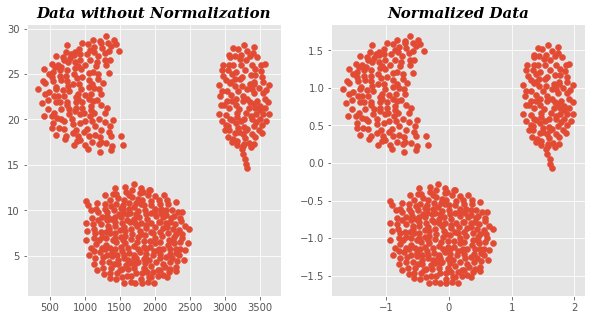

In [13]:
#Apply pre-processing steps over your data that you think necessary (feature scaling, normalization)
X = data[[0,1]]

X = X.values[:, 0:2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.scatter(X[:, 0], X[:,1])
ax1.set_title('Data without Normalization', fontdict=title_font)

# normalizing the data with feature scaling
before_normalization = deepcopy(X)
display(HTML(str("<font size=4><b> Normalization </b></font>")))
normalized_data = normalize(X)
for feature_number in range(X.shape[1]):
  print("Feature", feature_number, "before and after normalization [ min max ]:", "[", min(before_normalization[:,feature_number]), max(before_normalization[:,feature_number]), "]", "->", "[", round(min(normalized_data[:,feature_number]), 2), round(max(normalized_data[:,feature_number]),2), "]")

ax2.scatter(normalized_data[:, 0], normalized_data[:,1])
ax2.set_title('Normalized Data', fontdict=title_font)

plt.show()


### **K-Means**

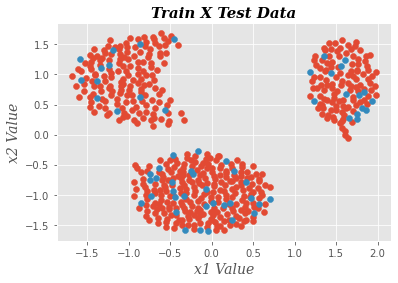

In [14]:
# Split your data into training/test sets (90/10)
train_db, test_db = train_test_split(normalized_data, test_size=0.1)

#Plotting train vs test dataset
plt.scatter(train_db[:, 0], train_db[:,1])
plt.scatter(test_db[:, 0], test_db[:,1])

plt.xlabel('x1 Value', fontdict=axis_font)
plt.ylabel('x2 Value', fontdict=axis_font)
plt.title('Train X Test Data', fontdict=title_font)
plt.show()

display(HTML(str("<font size=4><b> Databases Sizes </b></font>")))
display(HTML(str("<font size=2><b> Train: </b></font>" + str(train_db.shape[0]) + " x "+ str(train_db.shape[1]))))
display(HTML(str("<font size=2><b> Test: </b></font>" + str(test_db.shape[0]) + " x "+ str(test_db.shape[1]))))

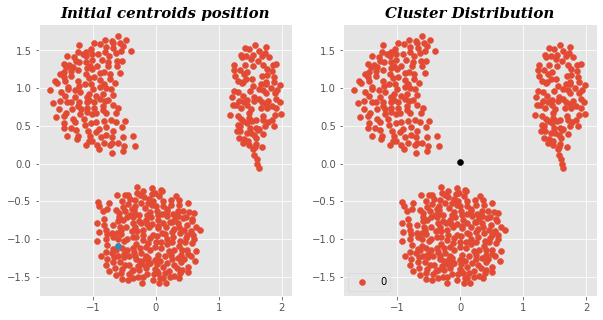

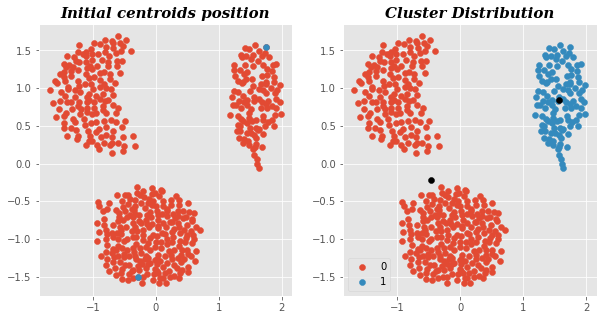

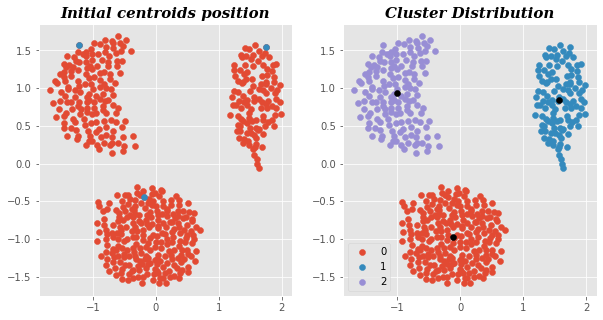

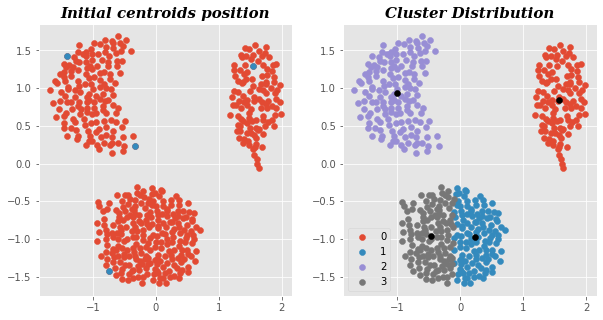

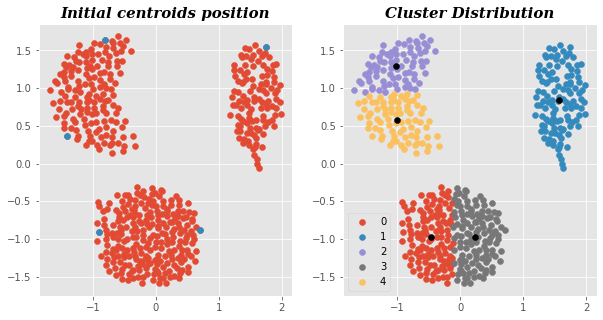

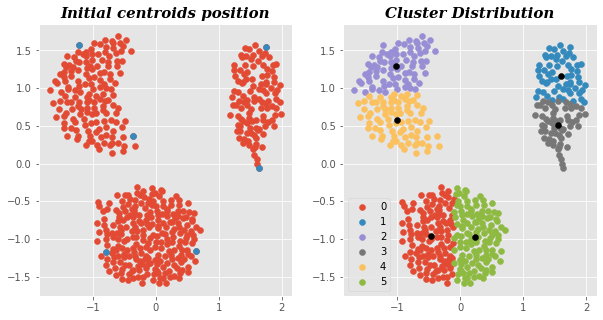

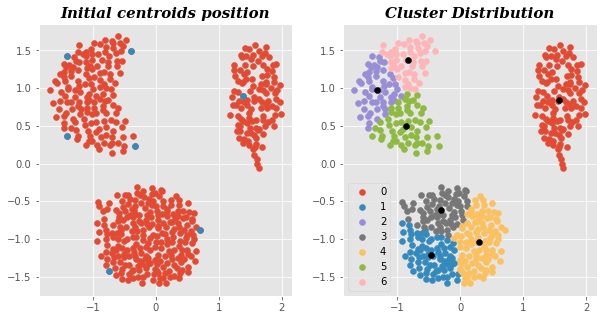

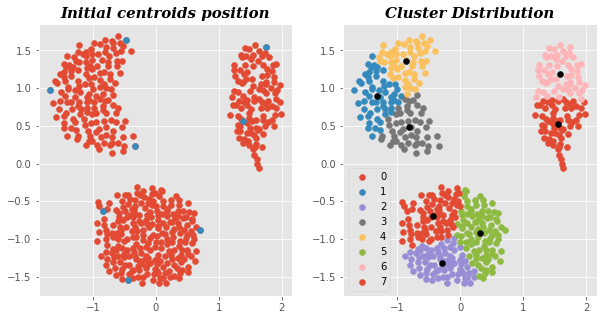

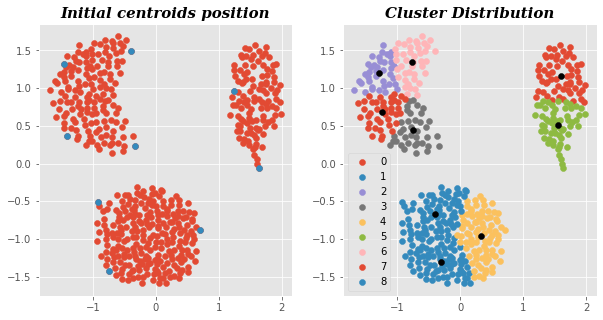

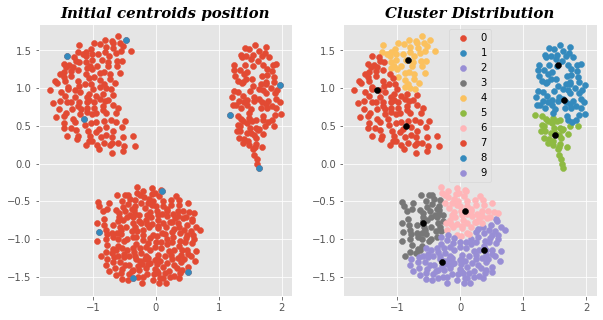

In [15]:
# plotting clusters, with k ranging from 1 to 10, initialized by kmeans++, to verify the best K value with elbow method
display(HTML(str("<font size=5><b> Elbow Method </b></font>")))

centroids_range = range(1,11)
elbow_values = []
for c in centroids_range:
  cent, center_assignment = kmeans(train_db, c , 'kmeans-plusplus')
  labels, distance = pairwise_distances_argmin_min(X=train_db, Y=cent, metric='euclidean')

  #calculating elbow values
  elbow_values.append(distance.sum())

# using silhouette coefficient to discover ideal number of clusters
#silhouette_score(copy_of_initial_data, X['Cluster'])

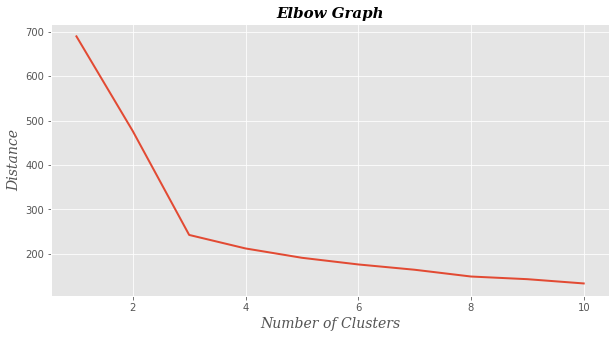

In [16]:
# plotting the elbow graph
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(centroids_range, elbow_values, linewidth=2)
ax1.set_title('Elbow Graph', fontdict=title_font)
ax1.set_ylabel('Distance', fontdict=axis_font)
ax1.set_xlabel('Number of Clusters', fontdict=axis_font)
plt.show()

Comparing the plots it is possible to see that the ideal number of clusters is 3, which is proved by the elbow graph.

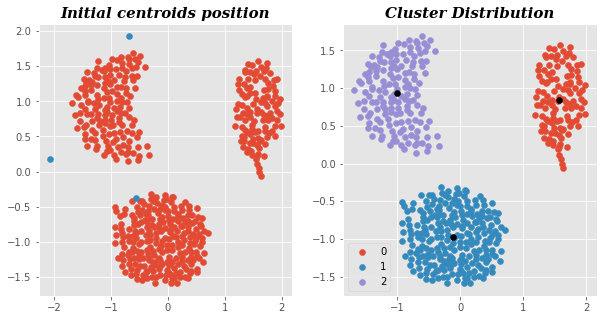

Random start execution time: 0.4309561252593994 s


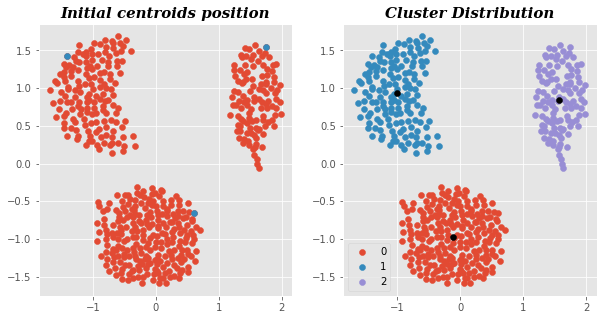

K Means++ start execution time: 0.4455876350402832 s


In [17]:
# random vs k means++ initializing with 3 clusters
start_time = time.time()
cent, center_assignment = kmeans(train_db, 3, 'random')
end_time = time.time()
print("Random start execution time:", end_time - start_time, "s")

start_time = time.time()
cent, center_assignment = kmeans(train_db, 3, 'kmeans-plus-plus')
end_time = time.time()
print("K Means++ start execution time:", end_time - start_time, "s")

When we compare the execution time of each initialization type, the K-Means++ and the random, we can observe that the random initialization is slightly faster, but inaccurate, when compared with the K-means++. The K-means++ is slower because it has to go through all the points to arrive at the best startup of the clusters. 

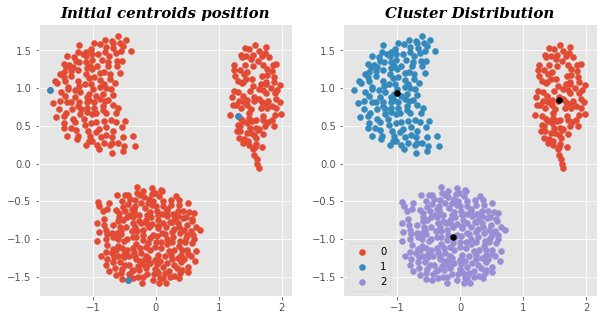

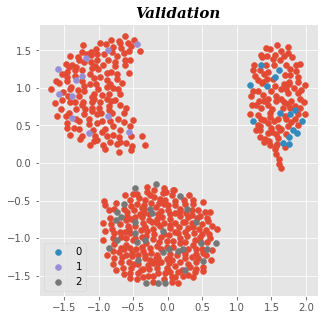

In [18]:
#Choose your best models and test them with the test set. Show to which cluster the new data has been assigned
#training k means with training part of dataset
centroids, clusters = kmeans(train_db, 3, 'kmeans-plus-plus')

#predicting datapoints with test part of dataset
pred = []
for points in test_db:
  pred.append(kmeans_predict(points, centroids))

fig, ax1 = plt.subplots(figsize=(5,5))
ax1.scatter(train_db[:, 0], train_db[:,1])
for g in np.unique(pred):
  ix = np.where(pred == g)
  ax1.scatter(test_db[ix,0], test_db[ix,1], label = g)
ax1.set_title('Validation', fontdict=title_font)
ax1.legend()
plt.show()

In [19]:
# average silhouette score for k = 3
silhouette_avg = silhouette_score(train_db, clusters)
display(HTML(str("<font size=3><b> The average silhouette score is : </b></font>" + str(round(silhouette_avg, 2)))))

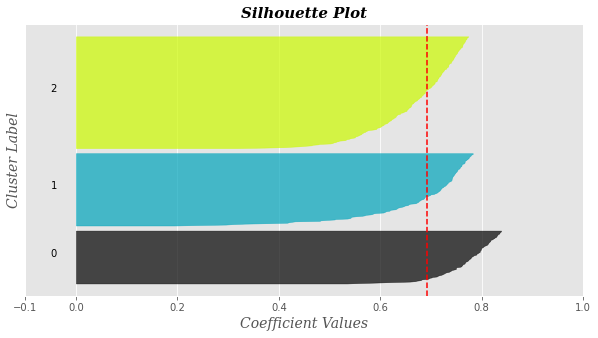

In [20]:
# plotting the silhouette score
import matplotlib.cm as cm

sample_silhouette_values = silhouette_samples(train_db, clusters)
clusters = np.array(clusters)
fig, ax1 = plt.subplots(figsize=(10,5))
y_lower = 10
for i in range(0,3):    
  ith_cluster_silhouette_values = \
      sample_silhouette_values[clusters == i]

  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i

  color = cm.nipy_spectral(float(i) / 3)
  ax1.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)

  ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  y_lower = y_upper + 10  # 10

ax1.set_title("Silhouette Plot", fontdict=title_font)
ax1.set_xlabel("Coefficient Values", fontdict=axis_font)
ax1.set_ylabel("Cluster Label", fontdict=axis_font)

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

Analyzing the silhouette score of the clusters, we see that in clusters 0 and 1, more than 50% of the data points contained in them have results better than the mean of the silhouette score and practically all of the cluster 2 has silhouette score values higher than the mean. Therefore, the number of appropriate clusters is 3.

### **DBSCAN**

In [21]:
db = DBSCAN(0.25, 5)
clusters = db.fit(train_db)

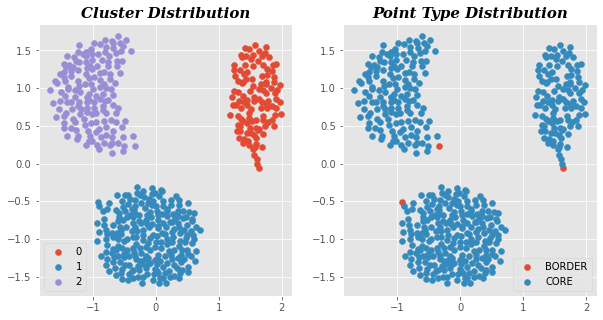

In [22]:
display(HTML(str("<font size=4><b> DBSCAN </b></font>")))
import operator
sorted_x = dict(sorted(db.point_type.items(), key=operator.itemgetter(0)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
for g in np.unique(db.labels):
    ix = np.where(db.labels == g)
    ax1.scatter(train_db[ix,0], train_db[ix,1], label = g)
ax1.set_title('Cluster Distribution', fontdict=title_font)
ax1.legend()

for g in np.unique(np.array(list(sorted_x.values()))):
    ix = np.where(np.array(list(sorted_x.values())) == g)
    ax2.scatter(train_db[ix,0], train_db[ix,1], label = g)
ax2.set_title('Point Type Distribution', fontdict=title_font)
ax2.legend()

plt.show()

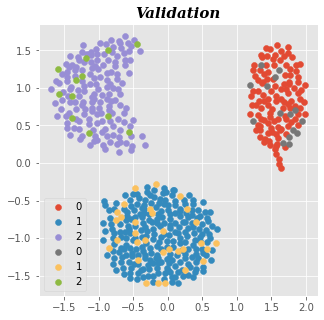

In [24]:
# predicting the values using DB Scan
labels = db.predict(test_db)

fig, ax1 = plt.subplots(figsize=(5,5))
for g in np.unique(db.labels):
    ix = np.where(db.labels == g)
    ax1.scatter(train_db[ix,0], train_db[ix,1], label = g)
    
for g in np.unique(labels):
    ix = np.where(labels == g)
    ax1.scatter(test_db[ix,0], test_db[ix,1], label = g)

ax1.set_title('Validation', fontdict=title_font)
ax1.legend()
plt.show()

When we validate the DBSCAN with 10% of the test data, we see that all the points are in the expected clusters, based on the algorithm metrics.

In [25]:
silhouette_avg = silhouette_score(train_db, db.labels)
display(HTML(str("<font size=3><b> The average silhouette score is : </b></font>" + str(round(silhouette_avg, 2)))))

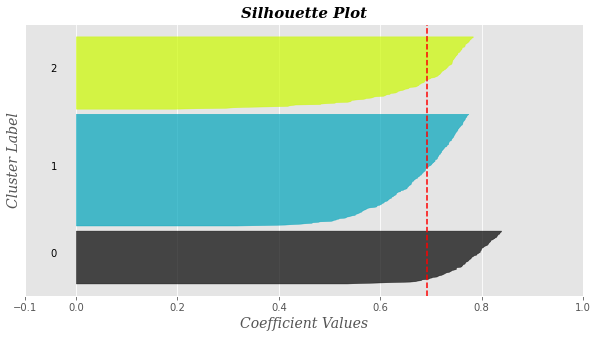

In [26]:
# plotting the silhouette graph based on DB Scan results
import matplotlib.cm as cm

sample_silhouette_values = silhouette_samples(train_db, db.labels)

fig, ax1 = plt.subplots(figsize=(10,5))
y_lower = 10
for i in range(len(db.clusters)):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[db.labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / len(db.clusters))
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10

ax1.set_title("Silhouette Plot", fontdict=title_font)
ax1.set_xlabel("Coefficient Values", fontdict=axis_font)
ax1.set_ylabel("Cluster Label", fontdict=axis_font)

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

To the best of our knowledge, the mean of the silhouette score with a value of 0.69 is a good result, closer to 1. The distribution analysis of silhouette score shows that the achieved results are very close to the ones we have on kmeans. While the cluster 1 presents values of silhouette score better than the mean, the cluster 0 and 2 have a greater number of values lower than the mean. 

### Part I-B: Implementing using another dataset
* **Description**: This dataset summarizes the behavior of credit card users in a given period of time. 
* **Features used**: 17 features: Balance, Balance Frequency, Purchases, One-Off Purchases, Installments Purchases, Cash Advance, Purchases Frequency, One-Off Purchases Frequency, Purchases Installment Frequency, Cash Advance Frequency, Cash Advance Transactions, Purchases Transactions, Credit Limits, Payments, Minimum Payments, Percent of Full Payment and Tenure
* **Dataset size**: 8950 entries and 18 features (17 excluding ID column)

In [27]:
# removing outliers of the data
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.95))
    x = x.clip(lower=x.quantile(0.1))
    return x

In [33]:
# getting the data
data = pd.read_csv('dataset-credit.csv')

# understanding the data
print(data.info())

# filling the missing values with the median value of the column
data.loc[:,data.columns] = data.loc[:,data.columns].fillna(data[data.columns].median())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [34]:
num_var = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
           'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
           'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']

# removing outliers          
data[num_var] = data[num_var].apply(lambda x: outlier_capping(x))

In [35]:
#Apply pre-processing steps over your data that you think necessary (feature scaling, normalization)
df1 = data.iloc[:, 1:18] #exclude the ID

# transforming a pd dataframe to np array
df1 = df1.values[:, 0:17]

before_normalization = deepcopy(df1)

# normalizing dataset with feature scaling
normalized_dataset_credit = normalize(df1) 

display(HTML(str("<font size=4><b> Normalization </b></font>")))
for feature_number in range(df1.shape[1]):
  print("Feature", feature_number, "before and after normalization [ min max ]:", "[", round(min(before_normalization[:,feature_number]),2), round(max(before_normalization[:,feature_number]),2), "]", "->", "[", round(min(normalized_dataset_credit[:,feature_number]), 2), round(max(normalized_dataset_credit[:,feature_number]),2), "]")



Feature 0 before and after normalization [ min max ]: [ 23.58 5909.11 ] -> [ -0.85 2.64 ]
Feature 1 before and after normalization [ min max ]: [ 0.0 1.0 ] -> [ -3.7 0.52 ]
Feature 2 before and after normalization [ min max ]: [ 0.0 3998.62 ] -> [ -0.75 2.89 ]
Feature 3 before and after normalization [ min max ]: [ 0.0 2671.09 ] -> [ -0.6 2.98 ]
Feature 4 before and after normalization [ min max ]: [ 0.0 1750.09 ] -> [ -0.68 2.84 ]
Feature 5 before and after normalization [ min max ]: [ 0.0 4647.17 ] -> [ -0.61 2.84 ]
Feature 6 before and after normalization [ min max ]: [ 0.0 1.0 ] -> [ -1.22 1.27 ]
Feature 7 before and after normalization [ min max ]: [ 0.0 1.0 ] -> [ -0.68 2.67 ]
Feature 8 before and after normalization [ min max ]: [ 0.0 1.0 ] -> [ -0.92 1.6 ]
Feature 9 before and after normalization [ min max ]: [ 0.0 0.58 ] -> [ -0.72 2.58 ]
Feature 10 before and after normalization [ min max ]: [ 0.0 15.0 ] -> [ -0.64 2.86 ]
Feature 11 before and after normalization [ min max ]:

In [36]:
# Split your data into training/test sets (90/10)
train_credit_db, test_credit_db = train_test_split(normalized_dataset_credit, test_size=0.1)

display(HTML(str("<font size=4><b> Databases Sizes </b></font>")))
display(HTML(str("<font size=2><b> Train: </b></font>" + str(train_credit_db.shape[0]) + " x "+ str(train_credit_db.shape[1]))))
display(HTML(str("<font size=2><b> Test: </b></font>" + str(test_credit_db.shape[0]) + " x "+ str(test_credit_db.shape[1]))))

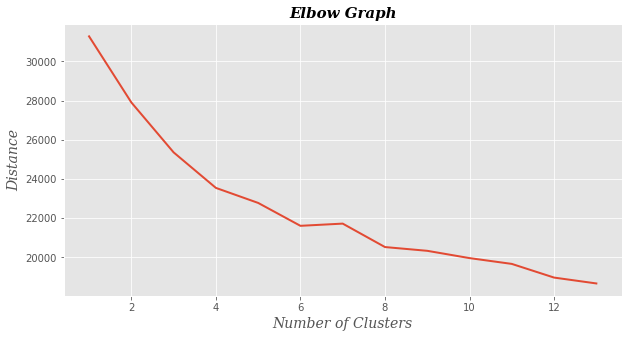

In [37]:
#Evaluate a different number of clusters and their effect in the tasks to select the best configuration (silhouette coefficient, elbow, among others)
centroids_range = range(1,14)
elbow_values = []
for c in centroids_range:
  cent, clust = kmeans(train_credit_db, c , 'kmeans-plusplus')
  labels, distance = pairwise_distances_argmin_min(X=train_credit_db, Y=cent, metric='euclidean')
  elbow_values.append(distance.sum())

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(centroids_range, elbow_values, linewidth=2)
ax1.set_title('Elbow Graph', fontdict=title_font)
ax1.set_ylabel('Distance', fontdict=axis_font)
ax1.set_xlabel('Number of Clusters', fontdict=axis_font)
plt.show()


In [38]:
#Choose your best models and test them with the test set. Show to which cluster the new data has been assigned
clusters, clust_t = kmeans(train_credit_db, 4, 'kmeans-plus-plus')

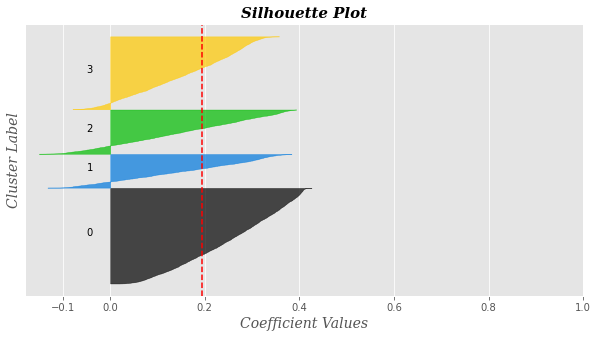

In [39]:
silhouette_avg = silhouette_score(train_credit_db, clust_t)
display(HTML(str("<font size=3><b> The average silhouette score is : </b></font>" + str(round(silhouette_avg, 2)))))

sample_silhouette_values = silhouette_samples(train_credit_db, clust_t)
clust_t = np.array(clust_t)
fig, ax1 = plt.subplots(figsize=(10,5))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[clust_t == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 4)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10

ax1.set_title("Silhouette Plot", fontdict=title_font)
ax1.set_xlabel("Coefficient Values", fontdict=axis_font)
ax1.set_ylabel("Cluster Label", fontdict=axis_font)

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

As we can see, the silhouette score for this cluster configuration is small, near to 0, which may have been issued by an overlapping of the clusters. The distribution shows many values in the "left side" of the mean. In other words, the elbow method gives an uncertain value of 4 clusters, while the silhouette score for this configuration is bad.

### PCA

In [40]:
# Discovering the ideal number of features that better represents the data
N_COMPONENTS = 15

dt_norm = pd.DataFrame(df1, columns = data.columns[1:])

pca = PCA(n_components=N_COMPONENTS)
pca.fit(dt_norm)

pd.DataFrame({'Cumulative Variance' : np.cumsum(np.round(pca.explained_variance_ratio_ , decimals=4)*100)},
            index=range(1,16))

,Cumulative Variance
1,30.77
2,54.31
3,63.15
4,70.60
5,76.82
6,81.97
7,86.24
8,89.64
9,92.48
10,94.72


#### Cumulative Variance equals to 63%

In [41]:
# pca run for 3 dimensions/features and cumulative variance equals to 63%
pca_trans = pca.transform(dt_norm)
pca_trans = pd.DataFrame(pca_trans).iloc[:,:3]
pca_trans.columns = list(map(lambda x: f'pca_{x+1}', pca_trans.columns))

train_credit_db_pca, test_credit_db_pca = train_test_split(pca_trans.values, test_size=0.1)

centroids_range = range(1,14)
elbow_values = []
for c in centroids_range:
  cent, clust_pca2 = kmeans(train_credit_db_pca, c, 'kmeans-plusplus')
  labels, distance = pairwise_distances_argmin_min(X=train_credit_db_pca, Y=cent, metric='euclidean')
  elbow_values.append(distance.sum())

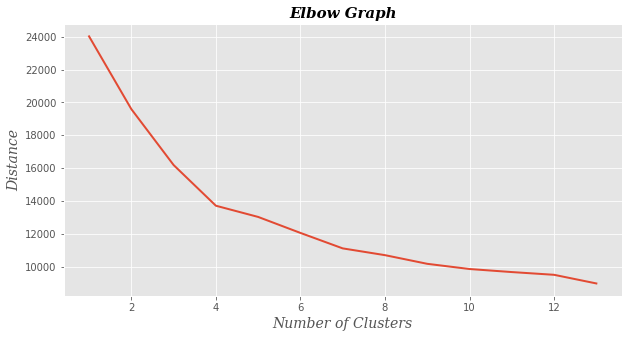

In [42]:
# plotting elbow graph for 3 dimensions and variance equals to 63%
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(centroids_range, elbow_values, linewidth=2)
ax1.set_title('Elbow Graph', fontdict=title_font)
ax1.set_ylabel('Distance', fontdict=axis_font)
ax1.set_xlabel('Number of Clusters', fontdict=axis_font)
plt.show()

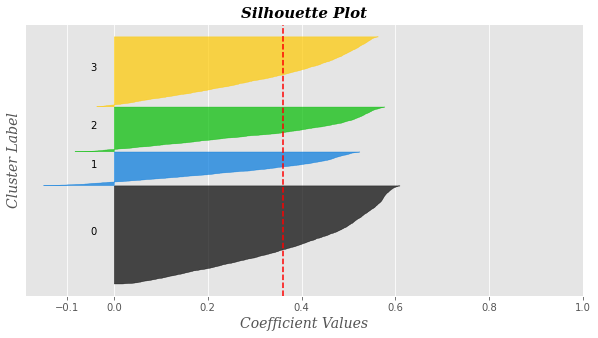

In [43]:
# silhouette score for dimensions equals to 3 and variance equals to 63%
cent, clust_pca2 = kmeans(train_credit_db_pca, 4, 'kmeans-plusplus')

silhouette_avg = silhouette_score(train_credit_db_pca, clust_pca2)
display(HTML(str("<font size=3><b> The average silhouette score is : </b></font>" + str(round(silhouette_avg, 2)))))

sample_silhouette_values = silhouette_samples(train_credit_db_pca, clust_pca2)
clust_pca2 = np.array(clust_pca2)
fig, ax1 = plt.subplots(figsize=(10,5))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[clust_pca2 == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 4)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10

ax1.set_title("Silhouette Plot", fontdict=title_font)
ax1.set_xlabel("Coefficient Values", fontdict=axis_font)
ax1.set_ylabel("Cluster Label", fontdict=axis_font)

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

The silhouette score is better when compared using all the columns, but still lower. Analysing the distribution, the clusters 1 and 2 have values less than 0, that can indicate overlapping or number of clusters incompatible to the data. However, this configuration, when compared with the above, looks good to generalizate the data. 

#### Cumulative Variance equals to 81%

In [44]:
# pca run for 6 dimensions/features and cumulative variance equals to 81%
pca_trans = pca.transform(dt_norm)
pca_trans = pd.DataFrame(pca_trans).iloc[:,:6]
pca_trans.columns = list(map(lambda x: f'pca_{x+1}', pca_trans.columns))

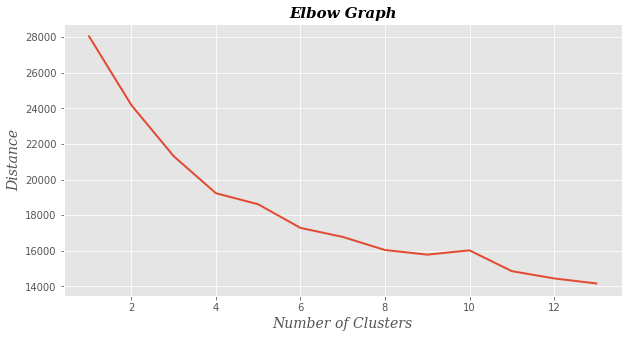

In [45]:
# elbow plot for dimensions equals to 6 and variance equals to 81%
train_credit_db_pca, test_credit_db_pca = train_test_split(pca_trans.values, test_size=0.1)

centroids_range = range(1,14)
elbow_values = []
for c in centroids_range:
  cent, clust_pca6 = kmeans(train_credit_db_pca, c, 'kmeans-plusplus')
  labels, distance = pairwise_distances_argmin_min(X=train_credit_db_pca, Y=cent, metric='euclidean')
  elbow_values.append(distance.sum())

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(centroids_range, elbow_values, linewidth=2)
ax1.set_title('Elbow Graph', fontdict=title_font)
ax1.set_ylabel('Distance', fontdict=axis_font)
ax1.set_xlabel('Number of Clusters', fontdict=axis_font)
plt.show()

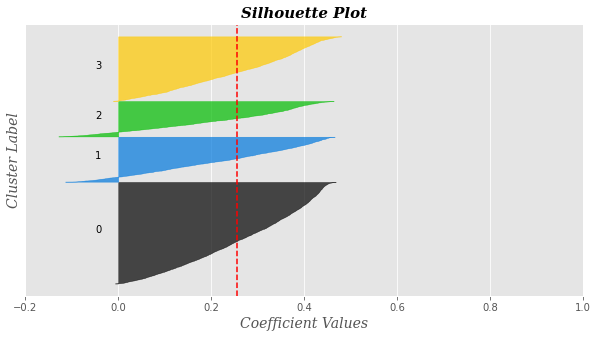

In [46]:
# silhouette score for dimensions equals to 6 and variance equals to 81%
cent, clust_pca2 = kmeans(train_credit_db_pca, 4, 'kmeans-plusplus')

silhouette_avg = silhouette_score(train_credit_db_pca, clust_pca2)
display(HTML(str("<font size=3><b> The average silhouette score is : </b></font>" + str(round(silhouette_avg, 2)))))

sample_silhouette_values = silhouette_samples(train_credit_db_pca, clust_pca2)
clust_pca2 = np.array(clust_pca2)
fig, ax1 = plt.subplots(figsize=(10,5))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[clust_pca2 == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 4)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10

ax1.set_title("Silhouette Plot", fontdict=title_font)
ax1.set_xlabel("Coefficient Values", fontdict=axis_font)
ax1.set_ylabel("Cluster Label", fontdict=axis_font)

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  
ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

With variance of 81%, we have 6 dimensions of data. The elbow returns the number of 4 clusters in K-Means. Analysing the silhouette score, the mean value is lower than the value using 63% of variance. Each cluster has a big amount of data positioned after the mean line in the graph, however it also shows negative values.

#### Cumulative Variance equals to 89%

In [47]:
# pca run for 8 dimensions/features and cumulative variance equals to 89%
pca_trans = pca.transform(dt_norm)
pca_trans = pd.DataFrame(pca_trans).iloc[:,:8]
pca_trans.columns = list(map(lambda x: f'pca_{x+1}', pca_trans.columns))

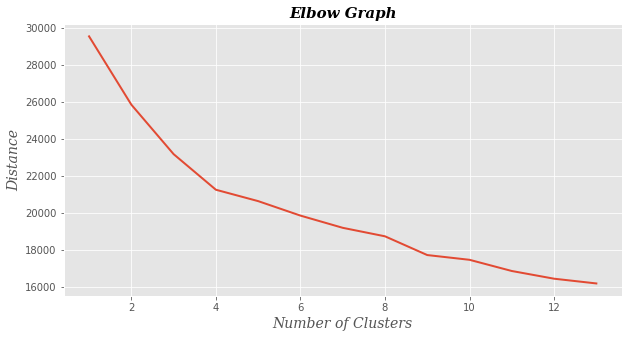

In [48]:
# elbow graph for dimensions equals to 8 and variance equals to 89%
train_credit_db_pca, test_credit_db_pca = train_test_split(pca_trans.values, test_size=0.1)

centroids_range = range(1,14)
elbow_values = []
for c in centroids_range:
  cent, clust_pca6 = kmeans(train_credit_db_pca, c, 'kmeans-plusplus')
  labels, distance = pairwise_distances_argmin_min(X=train_credit_db_pca, Y=cent, metric='euclidean')
  elbow_values.append(distance.sum())

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(centroids_range, elbow_values, linewidth=2)
ax1.set_title('Elbow Graph', fontdict=title_font)
ax1.set_ylabel('Distance', fontdict=axis_font)
ax1.set_xlabel('Number of Clusters', fontdict=axis_font)
plt.show()

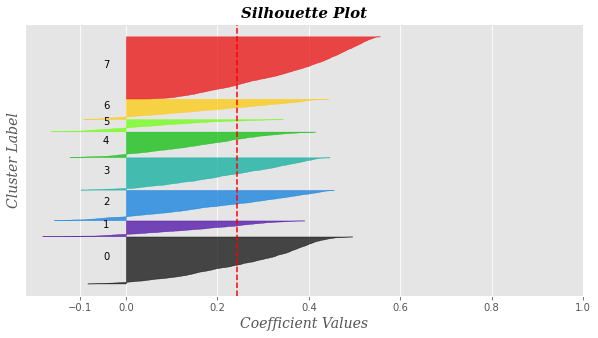

In [64]:
# silhouette score for dimensions equals to 8 and variance equals to 89%
cent, clust_pca2 = kmeans(train_credit_db_pca, 8, 'kmeans-plusplus')

silhouette_avg = silhouette_score(train_credit_db_pca, clust_pca2)
display(HTML(str("<font size=3><b> The average silhouette score is : </b></font>" + str(round(silhouette_avg, 2)))))

sample_silhouette_values = silhouette_samples(train_credit_db_pca, clust_pca2)
clust_pca2 = np.array(clust_pca2)
fig, ax1 = plt.subplots(figsize=(10,5))
y_lower = 10
for i in range(8):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[clust_pca2 == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 8)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10

ax1.set_title("Silhouette Plot", fontdict=title_font)
ax1.set_xlabel("Coefficient Values", fontdict=axis_font)
ax1.set_ylabel("Cluster Label", fontdict=axis_font)

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

Using 89% of variance we have a worse result when compared to the others variance values. The distribution of silhouette score is also bad, with a greater amount of data less or closer to 0. The best model, among 3, 4, 8 and 9 clusters, based on silhouette score, is with 4 clusters.

## Our Analysis - Wrapping Up
### 1) Normalization
**Did the feature scaling of the data impact the results?**

Yes, in both smaller and bigger datasets.

**How?**

In the dataset with only 2 features - which from now on we are referring to as a smaller dataset - it significantly impacted the results. In the smaller dataset, it is clear to see the division in three big clusters when we plot the points in a 2d graph, even without running the clustering algorithm. However, we observed that the K-Means algorithm was not performing well. 

After applying the feature scaling and producing standardized axis and data, we could see the expected centroids correctly positioned and the points assigned to the expected clusters. We used the method of standardization, rescaling the data (mean equals zero and variance equals one).

**Why?**

In our understanding, this happened because the data is represented in different ranges. The x axis ranges from 335 to 3636 while the y axis ranges from 1.95 to 29.15. After the standardization, these values become -1.68 to 1.98 in x axis and -1.6 to 1.69 in y axis. Since we are using Euclidean distance, both x and y positions started to equally contribute to the distance calculus after normalization.

The same behavior happened with the bigger dataset (the one we chose). We normalized all the 17 features.

### 2) Number of Clusters
**Did the number of clusters impact the results?**

Yes. For the smaller dataset, we could plot the difference of running the K Means algorithm ranging from 1 to 10 clusters. At a 2d dataset, it was easier to plot the data and see that it is grouped into 3 big conglomerates. The act of running the K Means with 3 clusters reinforced the initial hypothesis that the data is grouped in 3 big conglomerates.

Initially, we could not visually generate such a hypothesis in the bigger dataset. This dataset has 17 features (excluding the first, which is only an ID column) and we could not plot all of its features at the same plot ant time, since it has more than 3 dimensions. However, we ran the elbow method to discover the appropriate K value. We also explored the dimensionality reduction, which we are going to describe later.

**What do we have to say about the usage of the elbow method?**

In both datasets, the elbow method correctly pointed out the exact number of clusters to initialize the k means method. In the smaller dataset, we immediately see the elbow shape when the x value is 3. We used the silhouette method to assure this result, which we are going to describe below. 

In the bigger dataset, we found different values, depending on the variance of data, but in general 4 clusters. However, once the elbow format of the elbow graph is not conclusive in the bigger dataset, we also evaluate the ideal number of clusters using the silhouette, described below.

**What do we have to say about the usage of the silhouette method?**

In order to assure the output of the elbow method, we also applied the silhouette method. 

We calculated the average silhouette for the smaller dataset (0.69). By plotting the silhouette graph, with k = 3, all the clusters have values > average silhouette. Continuing the analysis of the smaller dataset, we also run the DB Scan with elbow and silhouette algorithms in order to verify if the calculated number of clusters is the same as the one calculated by K Means (which is 3). Both elbow and silhouette returned the expected number of clusters (3). The average silhouette with DB Scan also returned the same value of K Means (0.69). 

With the bigger dataset, the silhouette graph does not produce the best results, however, for k = 4, each cluster has a value higher than the average silhouette (0.2).

### 3) Initialization of centroids
**Did the initialization of the centroids impact the results?**

Yes. We describe how each initialization impacted below. 

**What do we have to say about the random initialization?**

In many cases, the random initialization chose points that are distant from the optimized and final centroids, leading to wrong shapes of clusters. In that point, the K Means++ outperformed the results of initialization in most part of the cases (except the times that the random initialization chose points very close to the expected centroid).

In our understanding, K Means++ avoids the chance of randomly choosing poor centroids. 

### 4) Dimensionality Reduction
**Did the dimensionality reduction impact the results??**

Yes. The time of execution is better when we reduce the dimensionality, and even better values of silhouette score when compared to the execution of the non-reduced dataset. We calculated the variance and decided to run PCA with 3 different variances, with 3, 6 and 8 clusters. We also calculate the ideal number of clusters with elbow and silhouette methods considering each of the three chosen variances.
 

### 5) DB Scan
**What do we have to say about the results of DB SCan?**

The DB Scan produced the same cluster results of the K Means with K Means++ initialization.

### 6) Extra Analysis
**What do we have to say about the execution time of...**

* **random vs K Means ++:** Using our datasets with a small number of features and rows, random and K Means++ took almost the same time to execute. In bigger datasets, it must vary, but in our understanding, the answer to "what is the fastest one?" will not be conclusive. In our point of view, K Means++ takes fewer iterations to reach the desired result, but the weighted probability at KMeans++ can take an expressive amount of time to run, different from the simple initial assignment of the random method. Also, the average execution time does not depend only on the size of the dataset, but also on how it is structured.

* **K Means with PCA vs K Means without PCA:** In the bigger dataset, we reduced the number of features. For these reasons, the K Means with PCA tends to run faster. 

* **K Means vs DB Scan:** We observed that K Means tends to run faster than DB Scan. It may have been caused by the recursive code choice in DB Scan.

## Responsabilities
**André Gomes Regino (RA 230252):** was responsible for Kmeans, Elbow method and other initialization.

**Hismael (RA 265684):** was responsible for DBSCAN, PCA and Kmeans+++.